# CRL - Causal Identifiability from Temporal Intervened Sequences

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://uvadl2c.github.io/)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://uvadl2c.github.io/)  
**Pre-trained models:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://uvadl2c.github.io/)   
**Authors:**
Angelos Nalmpantis, Danilo de Goede

<div style="text-align: justify">
Understanding the latent causal factors of a dynamical system from visual observations is a crucial step towards agents reasoning in complex environments. In this tutorial, we will have a closer look at CITRIS ([Lippe et al., 2022a](https://arxiv.org/abs/2202.03169)), a variational autoencoder framework that learns causal representations from temporal sequences of images in which underlying causal factors have possibly been intervened upon. As shown in the figure below, CITRIS utilizes both temporal consistency and interventions (orange) in order to identify causal variables (blue) from an image sequence. In contrast to previous work in causal representation learning, CITRIS considers causal variables as potentially multidimensional vectors. Furthermore, by introducing a normalizing flow, CITRIS can be easily extended to leverage and disentangle representations obtained by already pretrained autoencoders.


<!-- ![alt text](figures/CITRIS-setup.png) -->
<center width="100%"><img src="figures/CITRIS-setup.png" width="70%"></center>

<div style="text-align: justify">
In the remainder of this tutorial, we first provide a brief introduction to the recently emerging field of causal representation learning (CRL). Then, we will look into the inner workings of CITRIS in greater detail, before performing a number of experiments to demonstrate its capabilities.


Let’s start with importing our standard libraries here.

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

# Import CITRIS-VAE
sys.path.append('CITRIS')
from pytorch_lightning import LightningModule
from CITRIS.models.citris_nf import CITRISNF

## Causal Representation Learning

<div style="text-align: justify">
Machine Learning has become the most prominent approach in artificial intelligence. One major advantage of machine learning approaches over earlier AI paradigms is its ability to automatically learn useful features from high-dimensional observations. However, in doing so, machine learning methods generally only leverages statistical information (i.e., correlations) in data, and not the causal process that underlies how that data was generated in the first place. Consequently, they often struggle to perform tasks such that involve out-of-domain generalization and planning.
    
<div style="text-align: justify">
Causal inference, on the other hand, goes beyond the statistical description of data, and instead aims to reason about the effect of *interventions* in the system underlying the data. In order to perform such causal reasoning, it is required that the causal variables and their relations are provided beforehand. However, many real-world observations, such as objects in images, are not structured into such variables to begin with. 
    
<div style="text-align: justify">
Thus, an emerging field of research is *causal representation learning* (CRL), in which the task is to identify such causal variables including their relations from low-level data such as images or videos ([Schölkopf et al., 2021](https://arxiv.org/abs/2102.11107)). The central idea here is that a low-level observation $X$ is merely a view on the state of a causal system $C_1, \ldots, C_n$:
\begin{equation}
    X = G(C_1, \ldots, C_n),
\end{equation}
where $G: \mathcal{C} \rightarrow \mathcal{X}$ is some non-linear function that maps from the causal system's state space to the observational space. In CRL, we are then interested in approximating the inverse of $G$ (e.g. with a neural network) in order to map a low-level observation to high-level causal variables, as shown in the figure below.
<div>

<center width="100%"><img src="figures/crl-idea.png" width="50%"></center>

### Causal Setting: TempoRal Intervened Sequences (TRIS)

<div style="text-align: justify">
The setting in which CITRIS aims to identify causal variables is TempoRal Intervented Sequences (TRIS). In TRIS, we assume that the underlying latent causal process is a dynamic Bayesian network (DBN) over a set of $K$ causal factors $(C_1, C_2, \ldots, C_K)$. In the corresponding causal graph $G = (V, E)$, each node $i \in V$ is associated to the causal factor $C_i$, which can be scalar or vector valued, and each edge $(i, j) \in E$ represents a causal relation from $C_i$ to $C_j$: $C_i \to C_j$. 

<div style="text-align: justify">
TRIS further assumes that each causal factor $C_i$ is instantiated at each time step $t$, denoted $C_i^t$, and its causal parents can only be causal factors at time $t - 1$. In other words, we assume that DBN resembles a temporal latent causal process with $K$ causal factors $(C_1^t, C_2^t, \ldots, C_K^t)_{t=1}^T$ that change over time according to the temporal dynamics governed by the DBM. Crucially, in TRIS, some causal factors might have been intervened upon at each time step, and we have access to the corresponding intervention targets (but not the intervention values). We denote these intervention targets by the binary vector $I^t \in \{0, 1\}^K$, whose $i$-th component is 1 if and only if the causal factor $C_i$ has been intervened upon at time $t$ (i.e., $C_i^t$ has been intervened upon).

<div style="text-align: justify">
It is important to note that we never obserserve the causal factors $(C^t)_{t=1}^T$ in TRIS, and instead only have access to a temporal sequence of high-level observiations $(X^t)_{t=1}^T$ along with the corresponding intervention targets $(I^t)_{t=2}^T$. Each high-level observation represents a noisy and entangled view of all causal factors. Formally, $X^t = h(C_1^t, C_2^t, \ldots, C_K^t, E_o^t)$, where $E_o^t$ represents noise, and $h: \mathcal{C} \times \mathcal{E} \rightarrow \mathcal{X}$ is a function from the causal factor space $\mathcal{C}$ and the space of the noise variables $\mathcal{E}$ to the observation space $\mathcal{X}$. The overall set-up of TRIS is illustrated below, with observed variables shown in gray and latent variables in white.

<center width="100%"><img src="figures/TRIS.png" width="40%"></center>

<div style="text-align: justify">
It is noteworthy that the set-up of TRIS is general enough to be able to describe many dynamical systems. In fact, CITRIS (and iCITRIS ([Lippe et al., 2022b](https://arxiv.org/abs/2206.06169)), which we do not discuss in this notebook) have been successful in identifying the causal structure in settings that range from 3D rendered objects to pinball and pong.
<!-- <center width="100%"><img src="figures/datasets/interventional_pong.gif" width="800px"></center>
<center width="100%"><img src="figures/datasets/pinball.gif" width="800px"></center> -->

<div style="display: flex;">
  <div style="margin-left: 20px; margin-right: 20px;">
    <img src="figures/datasets/ball_in_boxes.gif" width="800px">
  </div>
  <div style="margin-right: 20px;">
    <img src="figures/datasets/causal-3dIdent.gif" width="800px">
  </div>
  <div style="margin-right: 20px;">
    <img src="figures/datasets/interventional_pong2.gif" width="800px">
  </div>
  <div style="margin-right: 20px;">
    <img src="figures/datasets/voronoi.gif" width="800px">
  </div>
  <div style="margin-right: 20px;">
    <img src="figures/datasets/pinball2.gif" width="800px">
  </div>
</div>

In the remainder of this tutorial, we will focus our attention on the Causal3DIdent dataset (second image above), which we describe in further detail next.

## Causal3DIdent

<div style="text-align: justify">
Now we will look into the Causal3DIdent dataset. It contains a sequence of images with the intervention targets at each time-step. In the below cell, we will load a small sample of the dataset.

In [ ]:
causal3d_dataset = dict(np.load('causal3d.npz'))
print(causal3d_dataset.keys())

<div style="text-align: justify">
The intervention targets declare which causal variables were intervened upon. In Causal3DIdent, we have 12 causal variables: x_position, y_position, z_position, alpha_rotation, beta_rotation, gamma_rotation, theta_spot_light, hue_object, hue_spot_light, hue_background, shape and material. Below you can see what causal variables were intervened at each time-step. The $i$-th intervention targets imply that the causal variables of the $(i-1)$-th image were intervened, resulting in the $i$-th image.

In [ ]:
time_steps = 4
print(causal3d_dataset['interventions'][0:time_steps])

<div style="text-align: justify">
In the next cell, we will plot a sequence of images. Note how the intervention targets, printed above, affect the object and the surrounding environment.

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
for i in range(time_steps):
    plt.subplot(1, time_steps, i+1)
    plt.imshow(causal3d_dataset['images'][i])
    plt.xticks([])
    plt.yticks([])
plt.show()

### Theoretical Framework of CITRIS

<div style="text-align: justify">
In TRIS, we generally cannot disentangle two causal factors if they are always intervened upon jointly, or, on the contrary, if they are never intervened upon. Furthermore, multidimensional causal variables are not always identifiable in TRIS as interventions might only affect a subset of its dimensions. Instead, we may only be able to identify *minimal causal variables*, which only model the information of a causal factor that is strictly affected by a provided intervention.

<div style="text-align: justify">
To formalize the notion of minimal causal variables, consider an invertible map $s_i: \mathcal{D}_i^{M_i} \rightarrow \mathcal{D}_i^\text{var} \times \mathcal{D}_i^\text{inv}$ that splits each causal variable $C_i^t$ into an *intervention-dependent* part $s^\text{var}_i(C^{t}_i)$ and an *intervention-independent* part $s^\text{inv}_i(C^{t}_i)$ (note that this invertible map is not unique).  We are interested in identifying the split where $s^\text{var}_i(C^{t}_i)$ *only* contains information that truly depends on the intervention. Under this split, $s^\text{var}_i(C^{t}_i)$ is defined as the *minimal causal variable* and denoted by $s^{\text{var}^*}_i(C^{t}_i)$.

<div style="text-align: justify">
In order to learn the minimal causal variables in TRIS, CITRIS approximates the inverse of the observation function based on data triplets $\{x^t, x^{t+1}, I^{t+1}\}$ by learning two components.
1. An invertible mapping from observations to latent space: $g_\theta: \mathcal{X} \to \mathcal{Z}$.
2. An assignment function $\psi: \llbracket1..M\rrbracket\to\llbracket0..K\rrbracket$ that maps each dimension of $\mathcal{Z}$ to a causal factor.

<div style="text-align: justify">
For the assignment function, $\psi(j)=0,j\in\llbracket1..M\rrbracket$ indicates that the latent dimension $z_j$ does not correspond to any dimension of the minimal causal variable, but rather to some dimension of $s^\text{inv}_i(C^{t}_i)$, and $z_{\psi_{i}}=\{z_j \mid j\in\llbracket1..M\rrbracket, \psi(j)=i\}$ denotes the set of latent variables that $\psi$ assigns to the causal variable $C_i$.

<div style="text-align: justify">
To encourage a disentanglement of the causal factors, CITRIS model a **transition prior** in the latent space that conditions each latent variable on exactly one of the intervention targets:
\begin{equation}
    p_{\phi}\left(z^{t+1}|z^{t}, I^{t+1}\right) = \prod_{i=0}^{K}p_{\phi}\left(z_{\psi_i}^{t+1}|z^{t}, I_{i}^{t+1}\right),
\end{equation}
where $I_0^{t+1}=0$. Combining the transition prior and the invertible mapping $g_\theta$, the objective of CITRIS is to maximize the following likelihood:
\begin{equation}
    \mathcal{L}_{\phi,\theta}(x^{t+1}|x^{t},I^{t+1})=\left|\frac{\partial g_{\theta}(x^{t+1})}{\partial x^{t+1}}\right|p_{\phi}(z^{t+1}|z^{t}, I^{t+1})
\end{equation}
If a model $\mathcal{M}$ maximizes the information content of $z_{\psi_0}$ under the constraint of maximizing this likelihood $\mathcal{L}_{\phi,\theta}(x^{t+1}|x^{t},I^{t+1})$ and no intervention variable is a deterministic function of any other intervention variable, then $\mathcal{M}$ is shown to identify any causal system $\mathcal{S}$ (i.e., it identifies the minimal causal variables of $\mathcal{S}$ up to an invertible transformation along with its causal graph).

### Practical Implementation of CITRIS

TODO

#### CITRIS-VAE

#### CITRIS-NF

In [2]:
CHECKPOINT_PATH = "./"

pretrained_CITRIS_path = os.path.join(CHECKPOINT_PATH, "citris" + ".ckpt")


if os.path.isfile(pretrained_CITRIS_path):
    print(f"Found pretrained model at {pretrained_CITRIS_path}, loading...")
    model = CITRISNF.load_from_checkpoint(pretrained_CITRIS_path)

Found pretrained model at ./citris.ckpt, loading...


In [35]:
triplets = dict(np.load('causal3d_triplets.npz'))
print(triplets.keys())

dict_keys(['images', 'mask'])


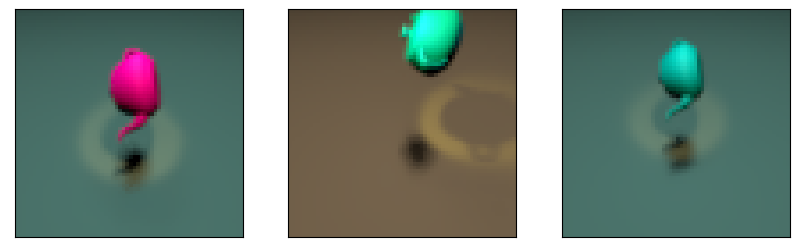

In [12]:
plt.rcParams['figure.figsize'] = [10, 5]
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(triplets['images'][0][i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [82]:
@torch.no_grad()
def encode(imgs):
    imgs = torch.from_numpy(imgs)[...,:3]
    imgs = imgs.permute(0, 1, 4, 2, 3)
    imgs = imgs.flatten(0, 1)
    imgs = imgs.float() / 255.0
    imgs = imgs * 2.0 - 1.0
    encs = model.autoencoder.encoder(imgs)
    encs = encs.unflatten(0, (-1, triplets['images'].shape[1]))
    return encs  

In [83]:
@torch.no_grad()
def triplet_reconstruction(imgs, source):
    x_encs = encode(imgs)
    batch_size = x_encs.shape[0]
    input_samples, _ = model.flow(x_encs[:,:2].flatten(0, 1))
    input_samples = input_samples.unflatten(0, (-1, 2))
    # Map the causal mask to a latent variable mask
    target_assignment = model.prior_t1.get_target_assignment(hard=True)
    if source.shape[-1] + 1 == target_assignment.shape[-1]:  # No-variables missing
        source = torch.cat([source, source[...,-1:] * 0.0], dim=-1)
    elif target_assignment.shape[-1] > source.shape[-1]:
        target_assignment = target_assignment[...,:source.shape[-1]]
    # Take the latent variables from encoding 1 respective to the mask, and encoding 2 the inverse
    mask_1 = (target_assignment[None,:,:] * (1 - source[:,None,:])).sum(dim=-1)
    mask_2 = 1 - mask_1
    triplet_samples = mask_1 * input_samples[:,0] + mask_2 * input_samples[:,1]
    # Decode by reversing the flow, and using the pretrained decoder
    model.autoencoder.eval()  # Set to eval in any case
    triplet_samples = model.flow.reverse(triplet_samples)
    triplet_rec = model.autoencoder.decoder(triplet_samples)
    return triplet_rec


In [84]:
triplet_rec = triplet_reconstruction(triplets['images'][0:3], triplets['mask'][0:3, [0,1,2,3,4,6,7,8,9,10]])


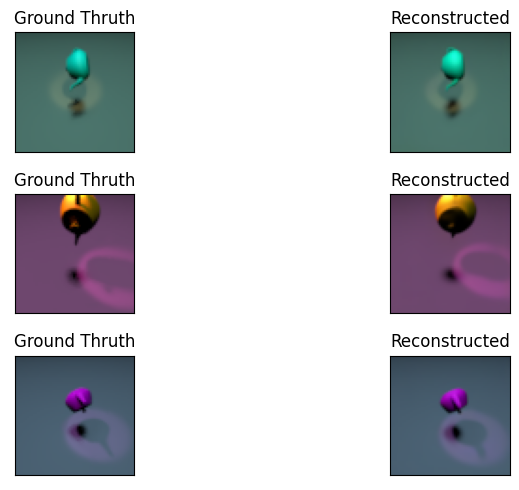

In [106]:
def normalize(imgs):
    imgs = imgs.numpy().transpose(1,2,0)
    imgs = (imgs + 1)/2
    imgs = imgs*255
    return imgs.astype(int)
    
for i in range(0, 6, 2):
    plt.subplot(3, 2, i+1)
    plt.title('Ground Thruth')
    plt.imshow(triplets['images'][int(i/2)][2])
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3, 2, i+2)
    plt.title('Reconstructed')
    plt.imshow(normalize(triplet_rec[int(i/2)]))
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

# Structure
- load pretrained citris and 
    (1) show R2 matrix, and (Angelos Friday-Saturday)
    (2) go with the triplet set (i.e. fig 7) (Angelos Tuesday)
    (3) add noise to color (eg) and plot both images (Angelos Wendsday-Thursday)